In [1]:
import sys
import numpy as np
from uncertainties import ufloat, unumpy
import uncertainties
import scipy
import matplotlib
import matplotlib.pyplot as plt
import mplhep as hep
plt.style.use(hep.style.CMS)

sys.path.append("..")

from hists.parameters import beamEnergies, synchrotronBeamEnergiesMap
from hist_loader import HistLoader
from sigma_over_e import SigmaOverEComputations, fitSigmaOverE, SigmaOverEPlotElement, plotSigmaOverMean, sigmaOverE_fitFunction, plotSCAsEllipse
from ntupleReaders.clue_ntuple_reader import ClueNtupleReader
#from fit import HistogramEstimates

## Regression for mu
Using fit fct ```a[0] * x**(a[1]) + a[2] ```
results are 
 - data : [-0.59127367, -0.54769765,  1.01810674]
 - sim : [-0.28349774, -0.2556718 ,  1.0477022 ]

In [13]:
reader = ClueNtupleReader("v42", "cmssw", "sim_proton_v46_patchMIP") # sim_proton_v46_patchMIP
loader = HistLoader(reader.histStore)

In [14]:
comp_sigma_e = SigmaOverEComputations(sigmaWindow=(1, 2.5))

In [15]:
sigma_e_results = comp_sigma_e.compute({beamEnergy : loader.getClue3DProjected(reader.datatype, beamEnergy) for beamEnergy in beamEnergies}, multiprocess=True)

2023-07-06 16:07:39.900961: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-07-06 16:07:39.902427: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-07-06 16:07:39.903124: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-07-06 16:07:39.903173: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-07-06 16:07:39.903544: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:1278] could not retrieve CUDA device count: CUDA_ERROR_NOT_INITIALIZED: initialization error
2023-07-06 16:07:39.903761: E tensorflow/compiler/xla/stream_executor/cuda/cuda_drive

In [16]:
sigma_e_results

{20: SigmaMuResult(mu=18.312825256638096+/-0.009756219698123876, sigma=0.9577405461716301+/-0.008007707829289128, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fd0ea7af220>, fitQuality='good'),
 30: SigmaMuResult(mu=27.870831754835297+/-0.010947561420026434, sigma=1.1890947378332535+/-0.009040251650771035, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fd0ea7da560>, fitQuality='good'),
 50: SigmaMuResult(mu=47.19631834614418+/-0.013718114091907029, sigma=1.5426349248642137+/-0.011594764214418674, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fd0ea7ada20>, fitQuality='good'),
 80: SigmaMuResult(mu=76.32837398824853+/-0.01991087245890587, sigma=1.9914433081072216+/-0.016509211193630323, fitResult=<zfit.minimizers.fitresult.FitResult object at 0x7fd0ea7ad120>, fitQuality='good'),
 100: SigmaMuResult(mu=95.84161276771778+/-0.02249785431259795, sigma=2.2149816408019762+/-0.018568807637588596, fitResult=<zfit.minimizers.fitresult.FitResult object at 0

In [17]:
beamEnergies_s = np.array(list(synchrotronBeamEnergiesMap.values()))
mu_vals = np.array([res.mu.nominal_value for res in sigma_e_results.values()])
sigma_vals = np.array([res.sigma.nominal_value for res in sigma_e_results.values()])

In [18]:
def fitFct(x, *a):
    #return a*np.log(beamEnergy) + b
    return a[0] * x**(a[1]) + a[2] 
popt, pcov = scipy.optimize.curve_fit(fitFct, xdata=beamEnergies_s, ydata=mu_vals/beamEnergies_s, p0=[1, -0.5, 0],
                                      maxfev=10**5)
popt

array([-0.28349774, -0.2556718 ,  1.0477022 ])

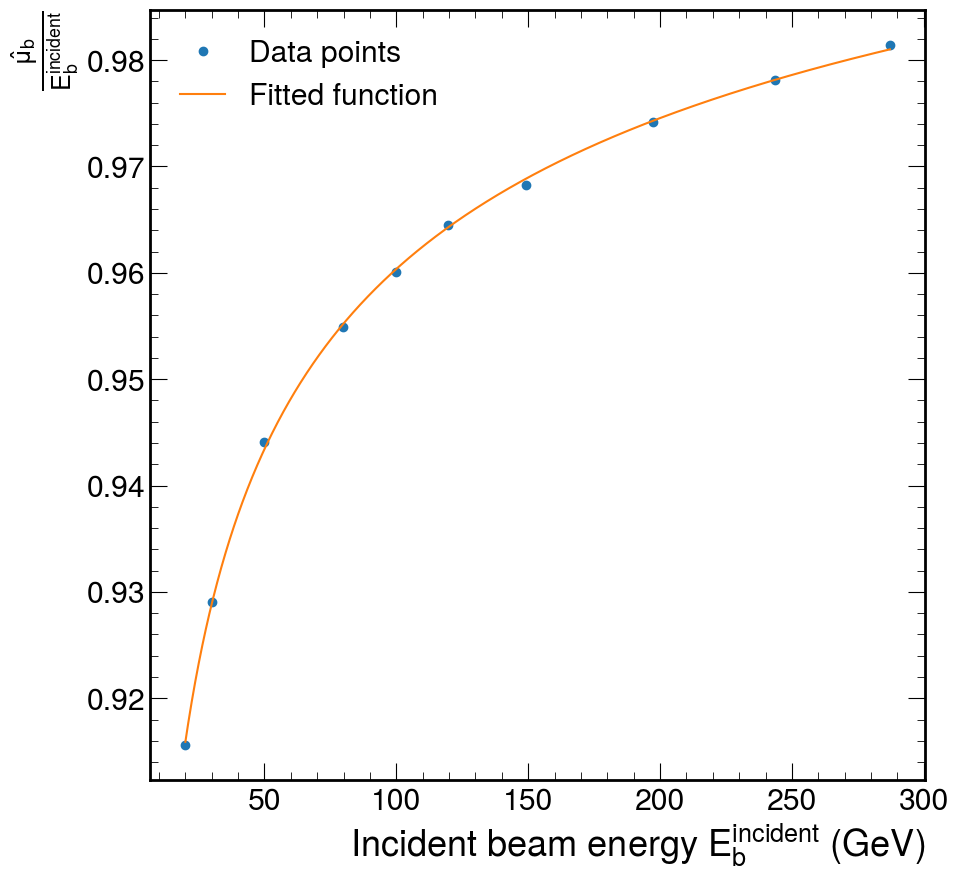

In [26]:
plt.plot(beamEnergies_s, mu_vals/beamEnergies_s, "o", label="Data points")
x_fct = np.linspace(beamEnergies_s[0], beamEnergies_s[-1], 1000)
plt.plot(x_fct, [fitFct(x, *popt) for x in x_fct], "-", label="Fitted function")
interp = scipy.interpolate.CubicSpline(beamEnergies_s, mu_vals/beamEnergies_s)
#plt.plot(x_fct, [interp(x) for x in x_fct], "-")
plt.xlabel(r"Incident beam energy $E^{incident}_b$ (GeV)")
plt.ylabel(r"$\frac{\hat{\mu}_b}{E^{incident}_b}$")
plt.legend()

In [9]:
beamEnergies_s, mu_vals/beamEnergies_s

(array([ 20.  ,  30.  ,  49.99,  79.93,  99.83, 119.65, 149.14, 197.32,
        243.61, 287.18]),
 array([0.90711306, 0.92069082, 0.94663497, 0.964591  , 0.97212941,
        0.97897577, 0.98273407, 0.98727282, 0.98684505, 0.98746277]))

## Regression for sigma

In [ ]:
loader.getClue3DProjected(reader.datatype, 50)

Hist(Regular(2000, 0, 350, name='clus3D_energy', label='3D cluster energy (GeV)'), storage=Double()) # Sum: 59086.0

In [ ]:
popt, pcov = scipy.optimize.curve_fit(fitFct, xdata=beamEnergies_s, ydata=sigma_vals/beamEnergies_s, p0=[1, -0.5, 0],
                                      maxfev=10**5)
popt

array([ 0.20210001, -0.50211124,  0.00155485])

Text(0, 1, 'Sigma')

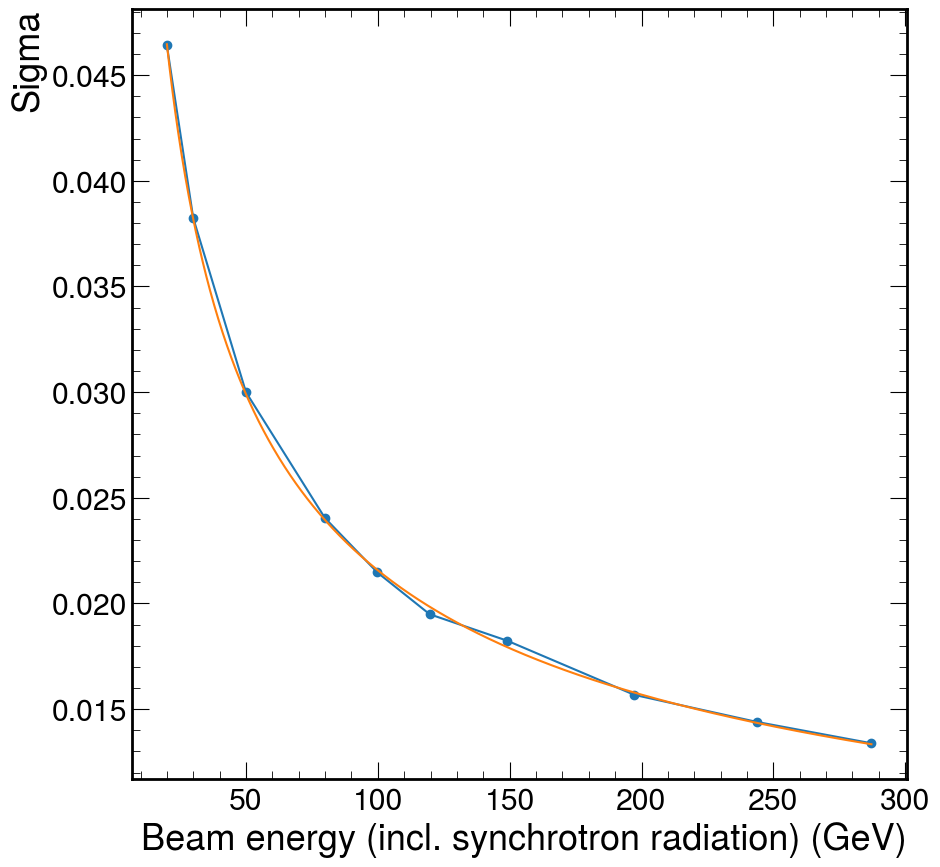

In [ ]:
plt.plot(beamEnergies_s, sigma_vals/beamEnergies_s, "o-")
x_fct = np.linspace(beamEnergies_s[0], beamEnergies_s[-1], 1000)
plt.plot(x_fct, [fitFct(x, *popt) for x in x_fct], "-")
plt.xlabel("Beam energy (incl. synchrotron radiation) (GeV)")
plt.ylabel(r"Sigma")